In [2]:
# Cell 1: Imports Yada Yada
import os
import glob
import numpy as np
import pandas as pd
import h5py
import uproot
import awkward as ak
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC, Precision, Recall

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc,
    precision_recall_curve, average_precision_score
)

print("TensorFlow Version:", tf.__version__)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Num GPUs Available: {len(gpus)}")
    for gpu in gpus:
        print(f"  - {gpu.name}")
else:
    print("No GPU detected. TensorFlow will use the CPU.")

2025-07-21 03:34:10.357031: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-21 03:34:10.388159: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-21 03:34:10.388184: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-21 03:34:10.388190: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-21 03:34:10.393129: I tensorflow/core/platform/cpu_feature_g

TensorFlow Version: 2.14.0
Num GPUs Available: 1
  - /physical_device:GPU:0


In [3]:
import os
import glob
import uproot
import h5py
import pandas as pd
import numpy as np
import awkward as ak
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# --- Configurations ---
# The list of features to be used for training the model.
selected_variables = [
    "jet1_pt",
    "jet1met_dphi",
    "met_sig", "met_pt"
]

# Base directories and file patterns from your notebook
base_dir_LQ      = "/home/sgoswami/monobcntuples/"
signal_masses_LQ = ["500", "1000", "1400", "2000", "2500", "2800"]
bkg_procs = ["ttbar", "wlnu", "znunu"]


# --- Helper Functions ---
def importance_shuffle(X, y=None):
    """Shuffles a DataFrame and an optional label array in unison."""
    idx = np.random.permutation(len(X))
    Xs = X.iloc[idx].reset_index(drop=True)
    if y is None: return Xs
    return Xs, y[idx]

def filter_ok(paths):
    """Filters out histogram and cutflow files."""
    return [f for f in paths if "_histogram" not in f and "_cutflow" not in f]

def load_h5_data(file_list, label):
    """Loads data from a list of HDF5 files."""
    dfs = []
    print(f"  Loading {len(file_list)} file(s)...")
    for f in file_list:
        try:
            with h5py.File(f, "r") as hf:
                cols0 = [n.decode() for n in hf["df/block0_items"][:]]
                vals0 = pd.DataFrame(hf["df/block0_values"][:], columns=cols0)
                cols1 = [n.decode() for n in hf["df/block1_items"][:]]
                vals1 = pd.DataFrame(hf["df/block1_values"][:], columns=cols1)
            df_single = pd.concat([vals0, vals1], axis=1)[selected_variables]
            print(f"    -> Loaded {len(df_single)} events from: {os.path.basename(f)}")
            dfs.append(df_single)
        except Exception as e:
            print(f"Warning: Could not process H5 file {f}. Reason: {e}")
    if not dfs: return pd.DataFrame(columns=selected_variables), np.array([])
    combined = pd.concat(dfs, axis=0).reset_index(drop=True)
    return combined, np.full(len(combined), label)


# --- Proportional Background Sampling Setup ---
target_yields = {
    'ttbar': 55420.2,
    'wlnu': 516779.0,
    'znunu': 702063.8,
}
_total_target_bkg = sum(target_yields.values())
bkg_proportions = {p: xs/_total_target_bkg for p, xs in target_yields.items()}


# --- Dataset Preparation Function ---
def prepare_LQ():
    """Prepares the Leptoquark dataset from H5 files with proportional background sampling."""
    print("--- Preparing Leptoquark (LQ) Dataset ---")

    # --- ADDED: Print initial target ratios ---
    print("\nInitial Target Proportions (from high-stats yields):")
    for proc, prop in bkg_proportions.items():
        print(f"  - {proc}: {prop:.2%}")

    # Find signal files
    sig_files = []
    for m in signal_masses_LQ:
        sig_files += filter_ok(glob.glob(os.path.join(base_dir_LQ, f"mass_{m}", "basicSel_mass_*.h5")))

    # Load all signal events to determine the total number of events (S)
    print("\nLoading signal files:")
    sig_df, sig_lbl = load_h5_data(sig_files, 1)
    S = len(sig_df)
    print(f"Loaded {S} total signal events.")

    # Calculate how many events to sample for each background process to match S
    bkg_counts = {p: int(round(S * bkg_proportions[p])) for p in bkg_procs}
    diff = S - sum(bkg_counts.values()); bkg_counts[bkg_procs[-1]] += diff

    bkg_parts, bkg_files_map = [], {}
    print("\nSampling background events proportionally...")
    for proc in bkg_procs:
        n_req = bkg_counts[proc]
        if n_req == 0: continue

        print(f"Processing background: {proc}")
        # Construct file paths for background H5 files
        if proc == 'wlnu':
            dirs = ['wenu_mc20e','wmunu_mc20e','wtaunu_mc20e']
            files = sum((glob.glob(os.path.join(base_dir_LQ, d, "*.h5")) for d in dirs), [])
        else:
            files = glob.glob(os.path.join(base_dir_LQ, f"{proc}_mc20e", "*.h5"))

        files = filter_ok(files)
        bkg_files_map[proc] = files
        if not files:
            print(f"  No files found for {proc}. Skipping.")
            continue

        # Load all available events for the process
        df_all, _ = load_h5_data(files, 0)
        if len(df_all) == 0:
            print(f"  No events loaded for {proc}. Skipping sampling.")
            continue

        # Sample the required number of events
        replace = n_req > len(df_all)
        print(f"  Requesting {n_req} events (replacement={replace})...")
        df_samp = df_all.sample(n=n_req, replace=replace, random_state=42).reset_index(drop=True)
        bkg_parts.append(df_samp)

    bkg_df = pd.concat(bkg_parts, axis=0).reset_index(drop=True)

    # Print final loaded ratios ---
    total_loaded_bkg = len(bkg_df)
    if total_loaded_bkg > 0:
        print("\nFinal Loaded Proportions (after sampling):")
        # To get the counts, we rely on the numbers we requested for sampling
        for proc, count in bkg_counts.items():
            final_prop = count / total_loaded_bkg
            print(f"  - {proc}: {final_prop:.2%}")

    bkg_df = importance_shuffle(bkg_df)

    # Combine signal and background into final dataset
    X_LQ = pd.concat([sig_df, bkg_df], axis=0).reset_index(drop=True)
    y_LQ = np.concatenate([sig_lbl, np.zeros(len(bkg_df), dtype=int)])
    return importance_shuffle(X_LQ, y_LQ), sig_files, bkg_files_map


# --- Final Data Loading and Splitting ---
(X_df, y_array), lq_sig_files, lq_bkg_files = prepare_LQ()

# --- Loading Summary ---
print("\n--- Files Loaded Summary ---")
print("\nLQ Signal Files:")
for f in sorted(lq_sig_files): print(f"  {f}")

print("\nLQ Background Files by Process:")
for proc, files in lq_bkg_files.items():
    if not files: continue
    print(f"  Process: {proc}")
    for f in sorted(files): print(f"    {f}")
print("----------------------------\n")

print(f"Final dataset shape: {X_df.shape}")
print(f"Final class distribution: {np.bincount(y_array)}")

# Split the data into training and validation sets
X_train_df, X_val_df, y_train, y_val = train_test_split(
    X_df, y_array, test_size=0.2, random_state=42, stratify=y_array
)

print(f"\nTrain set shape: {X_train_df.shape}")
print(f"Validation set shape:  {X_val_df.shape}")


--- Preparing Leptoquark (LQ) Dataset ---

Initial Target Proportions (from high-stats yields):
  - ttbar: 4.35%
  - wlnu: 40.56%
  - znunu: 55.10%

Loading signal files:
  Loading 6 file(s)...
    -> Loaded 10036 events from: basicSel_mass_500.h5
    -> Loaded 26820 events from: basicSel_mass_1000.h5
    -> Loaded 29067 events from: basicSel_mass_1400.h5
    -> Loaded 30319 events from: basicSel_mass_2000.h5
    -> Loaded 30544 events from: basicSel_mass_2500.h5
    -> Loaded 30542 events from: basicSel_mass_2800.h5
Loaded 157328 total signal events.

Sampling background events proportionally...
Processing background: ttbar
  Loading 1 file(s)...
    -> Loaded 591385 events from: basicSel_ttbar_mc20e.h5
  Requesting 6843 events (replacement=False)...
Processing background: wlnu
  Loading 3 file(s)...
    -> Loaded 1757384 events from: basicSel_wenu_mc20e.h5
    -> Loaded 2450997 events from: basicSel_wmunu_mc20e.h5
    -> Loaded 1833710 events from: basicSel_wtaunu_mc20e.h5
  Requesti

Data integrity check:
                 count        mean         std         min         25%  \
jet1_pt       251724.0  476.675788  310.650007  150.005432  242.432289   
jet1met_dphi  251724.0    2.904585    0.257383    0.412630    2.827714   
met_sig       251724.0   17.649096    4.880435    0.769567   13.696954   
met_pt        251724.0  509.787643  324.422701  200.000183  264.850380   

                     50%         75%          max  
jet1_pt       371.559235  636.256271  3349.296143  
jet1met_dphi    2.988307    3.074040     3.141591  
met_sig        16.766650   21.229762    41.545959  
met_pt        385.609695  676.496124  3375.253662  

Checking for NaN values:
jet1_pt         0
jet1met_dphi    0
met_sig         0
met_pt          0
dtype: int64


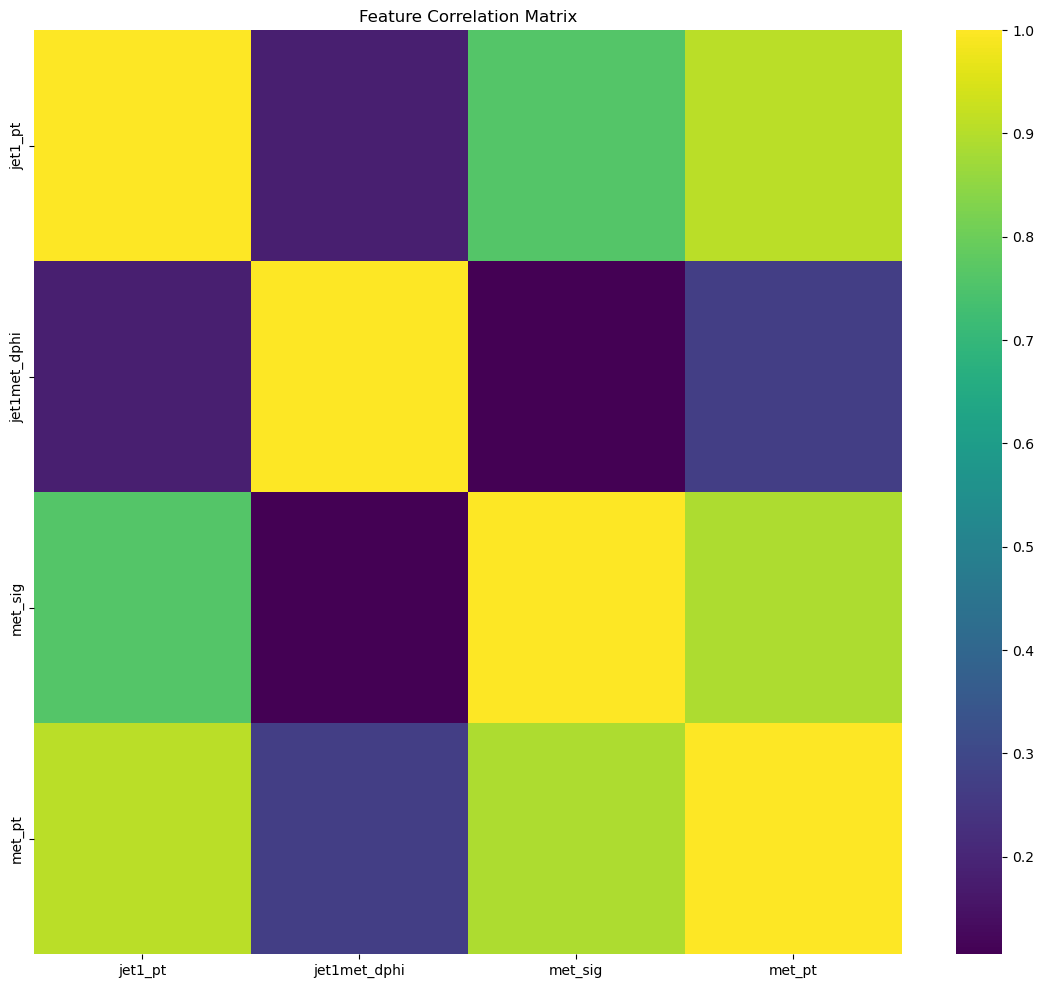

In [4]:
# Cell 3: Data Analysis & Visualization
import seaborn as sns

# Data integrity check
print("Data integrity check:")
print(X_train_df.describe().transpose())
print("\nChecking for NaN values:")
print(X_train_df.isna().sum())

# Feature Correlation Matrix
plt.figure(figsize=(14, 12))
correlation_matrix = X_train_df.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='viridis')
plt.title('Feature Correlation Matrix')
plt.show()

In [5]:
# Cell 4: Define Model, Optimizer, and Callbacks

def build_model(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128, kernel_initializer='he_normal', activation='gelu'),
        BatchNormalization(),
        Dense(64, kernel_initializer='he_normal', activation='gelu'),
        BatchNormalization(),
        Dense(32, kernel_initializer='he_normal', activation='gelu'),
        BatchNormalization(),
        Dense(1, kernel_initializer='he_normal', activation='sigmoid'),
    ])
    return model

# saving to .keras (old loader causes issues)

lr          = 5e-5
epochs      = 150
batch_size  = 512

metric_list = [
    AUC(name='auc'),
    'accuracy',
    Precision(name='precision'),
    Recall(name='recall')
]

callbacks = [
    EarlyStopping(
        monitor='val_auc',
        patience=20,
        mode='max',
        verbose=1,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_auc',
        factor=0.2,
        patience=7,
        mode='max',
        verbose=1,
        min_lr=1e-7
    ),
]

model = build_model(input_dim=X_train_df.shape[1])

model.compile(
    optimizer=Adam(learning_rate=lr),
    loss='binary_crossentropy',
    metrics=metric_list
)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               640       
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 batch_normalization_2 (Bat  (None, 32)                1

2025-07-21 03:34:20.023471: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7801 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


In [6]:
# Cell 5: Train Model

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_df.values)
X_val = scaler.transform(X_val_df.values)

print(f"Starting training with LR={lr}, BS={batch_size}, Epochs={epochs}")
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1
)
model.save("best_model_lq.keras", save_format="keras")

Starting training with LR=5e-05, BS=512, Epochs=150
Epoch 1/150


2025-07-21 03:34:23.127299: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x730b5c223ce0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-07-21 03:34:23.127323: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-07-21 03:34:23.130976: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-21 03:34:23.145205: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-07-21 03:34:23.213232: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


492/492 [==============================] - 6s 4ms/step - loss: 0.4651 - auc: 0.8653 - accuracy: 0.8010 - precision: 0.8239 - recall: 0.7656 - val_loss: 0.4202 - val_auc: 0.8877 - val_accuracy: 0.8149 - val_precision: 0.8404 - val_recall: 0.7775 - lr: 5.0000e-05
Epoch 2/150
492/492 [==============================] - 2s 4ms/step - loss: 0.4175 - auc: 0.8891 - accuracy: 0.8160 - precision: 0.8360 - recall: 0.7862 - val_loss: 0.4168 - val_auc: 0.8895 - val_accuracy: 0.8165 - val_precision: 0.8336 - val_recall: 0.7910 - lr: 5.0000e-05
Epoch 3/150
492/492 [==============================] - 2s 4ms/step - loss: 0.4154 - auc: 0.8903 - accuracy: 0.8168 - precision: 0.8348 - recall: 0.7898 - val_loss: 0.4158 - val_auc: 0.8899 - val_accuracy: 0.8167 - val_precision: 0.8372 - val_recall: 0.7864 - lr: 5.0000e-05
Epoch 4/150
492/492 [==============================] - 2s 4ms/step - loss: 0.4147 - auc: 0.8906 - accuracy: 0.8168 - precision: 0.8352 - recall: 0.7895 - val_loss: 0.4152 - val_auc: 0.8902 -

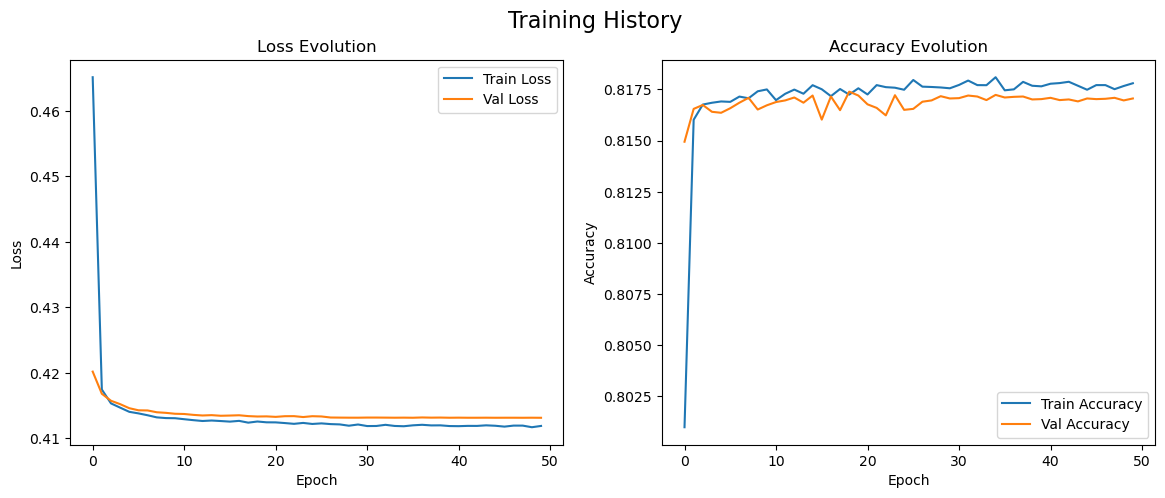

1967/1967 [==============================] - 2s 904us/step


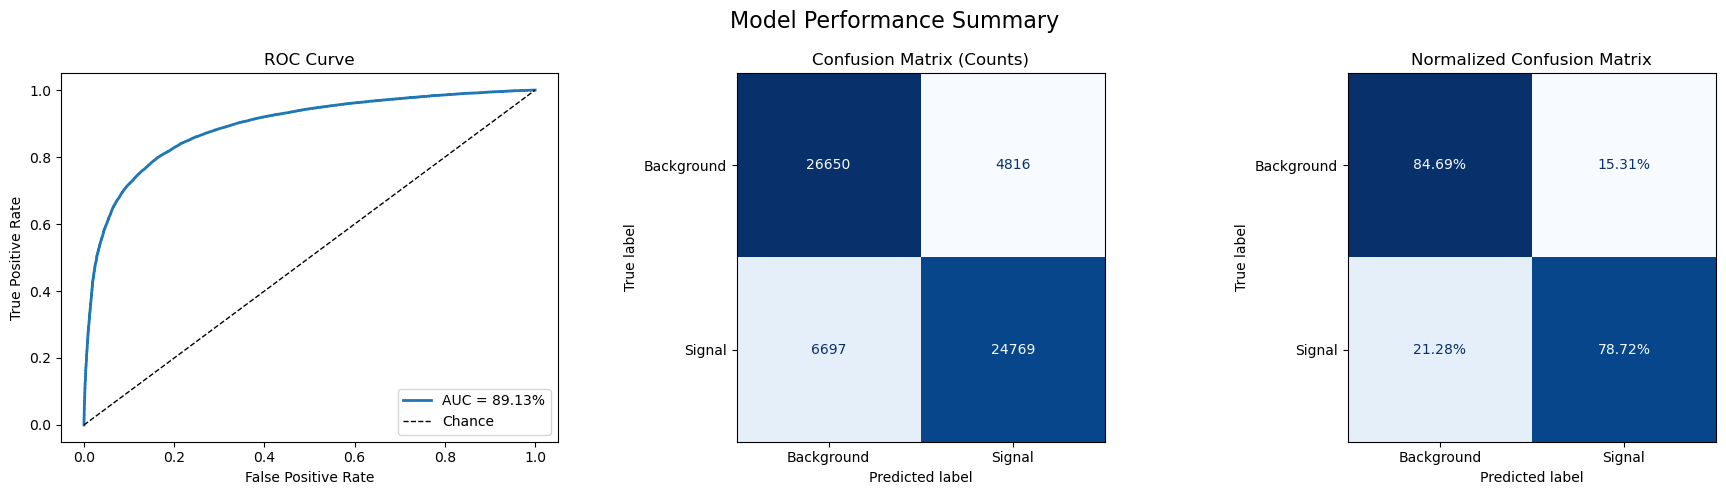

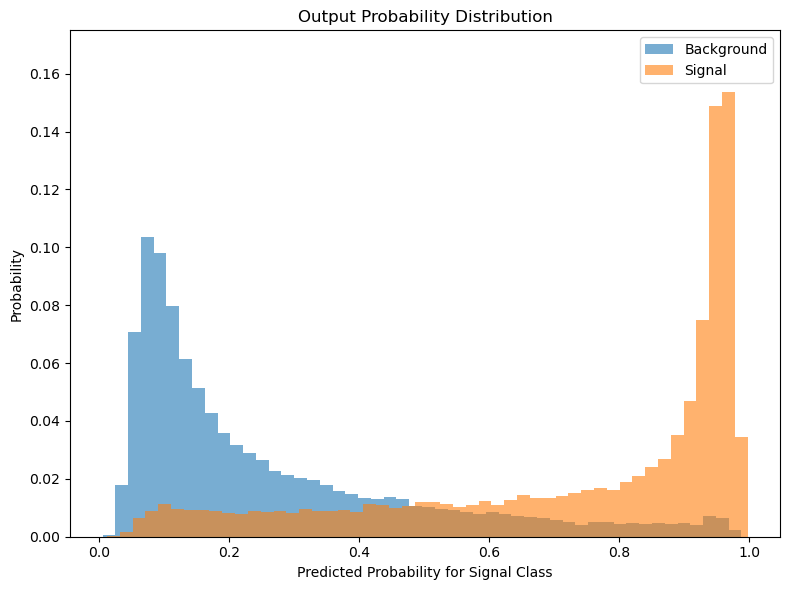

In [7]:
# Cell 6: Evaluate Model and Plot Results
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
# Plot Loss and Accuracy vs. Epoch
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Training History', fontsize=16)

ax1.plot(history.history['loss'], label='Train Loss')
ax1.plot(history.history['val_loss'], label='Val Loss')
ax1.set_title('Loss Evolution')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history.history['accuracy'], label='Train Accuracy')
ax2.plot(history.history['val_accuracy'], label='Val Accuracy')
ax2.set_title('Accuracy Evolution')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

y_pred_probs = model.predict(X_val).squeeze()
y_pred_class = (y_pred_probs > 0.5).astype(int)

y_pred_class = (y_pred_probs > 0.5).astype(int)
fpr, tpr, _ = roc_curve(y_val, y_pred_probs)
roc_auc = auc(fpr, tpr)
cm = confusion_matrix(y_val, y_pred_class)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Model Performance Summary', fontsize=16)

# Plot 1: ROC Curve
ax1.plot(fpr, tpr, label=f'AUC = {roc_auc*100:.2f}%', lw=2)
ax1.plot([0, 1], [0, 1], 'k--', lw=1, label='Chance')
ax1.set_title('ROC Curve')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.legend(loc='lower right')

# Plot 2: Confusion Matrix (Raw Counts)
disp1 = ConfusionMatrixDisplay(cm, display_labels=['Background', 'Signal'])
disp1.plot(ax=ax2, cmap='Blues', colorbar=False, values_format='d')
ax2.set_title('Confusion Matrix (Counts)')

# Plot 2A: Normalized Confusion Matrix (Percentages)
disp2 = ConfusionMatrixDisplay(cm_norm, display_labels=['Background', 'Signal'])
disp2.plot(ax=ax3, cmap='Blues', colorbar=False, values_format='.2%')
ax3.set_title('Normalized Confusion Matrix')

plt.tight_layout()
plt.show()

import numpy as np
import matplotlib.pyplot as plt

# split your predictions
probs_bg = y_pred_probs[y_val == 0]
probs_sig = y_pred_probs[y_val == 1]

# make weights that sum to 1
w_bg  = np.ones_like(probs_bg)  / probs_bg.size
w_sig = np.ones_like(probs_sig) / probs_sig.size

plt.figure(figsize=(8, 6))
# now each histogram is properly normalized so sum(bin_heights) == 1
plt.hist(probs_bg,  bins=50, alpha=0.6, label='Background', weights=w_bg)
plt.hist(probs_sig, bins=50, alpha=0.6, label='Signal',     weights=w_sig)

plt.xlabel('Predicted Probability for Signal Class')
plt.ylabel('Probability')         # now represents P(bin)
plt.title('Output Probability Distribution')
plt.legend()

# optionally force y‐axis to [0,1]
plt.ylim(0, 0.175)

plt.tight_layout()
plt.show()

--- Calculating and Plotting Feature Importance ---
Baseline Validation AUC: 0.8913


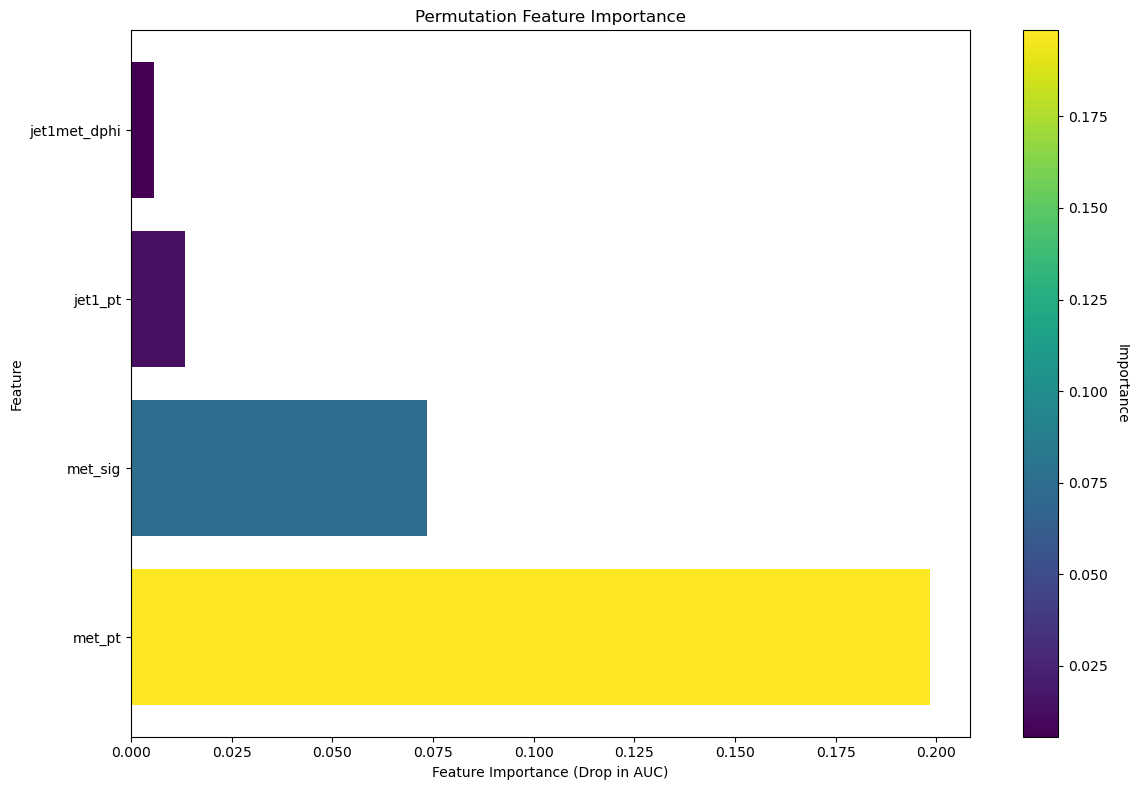

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import tensorflow as tf
from sklearn.metrics import roc_auc_score

print("--- Calculating and Plotting Feature Importance ---")

model = tf.keras.models.load_model('best_model_lq.keras')

y_pred_baseline = model.predict(X_val, batch_size=batch_size, verbose=0).squeeze()
baseline_auc = roc_auc_score(y_val, y_pred_baseline)
print(f"Baseline Validation AUC: {baseline_auc:.4f}")

importances = []

for i in range(X_val.shape[1]):
    X_val_permuted = X_val.copy()
    np.random.shuffle(X_val_permuted[:, i])

    y_pred_permuted = model.predict(X_val_permuted, batch_size=batch_size, verbose=0).squeeze()
    permuted_auc = roc_auc_score(y_val, y_pred_permuted)

    feature_importance = baseline_auc - permuted_auc
    importances.append(feature_importance)


importance_df = pd.DataFrame({
    'feature': selected_variables,
    'importance': importances
}).sort_values(by='importance', ascending=True)


import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))

cmap = plt.get_cmap('viridis')
norm = plt.Normalize(
    vmin=importance_df['importance'].min(),
    vmax=importance_df['importance'].max()
)


ax.barh(
    importance_df['feature'],
    importance_df['importance'],
    color=cmap(norm(importance_df['importance']))
)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Importance', rotation=270, labelpad=15)

ax.set_xlabel("Feature Importance (Drop in AUC)")
ax.set_ylabel("Feature")
ax.set_title("Permutation Feature Importance")
ax.invert_yaxis()

fig.tight_layout()
plt.show()

In [9]:
import uproot
import pandas as pd
import numpy as np
import tensorflow as tf
import os

print("--- Starting NTuple processing ---")
print("--- NOTE: Using a default event weight of 1.0 ---")

# Path to your trained Keras model.
# This model's input layer MUST match the number of features in the FEATURES list below.
MODEL_PATH = "/home/sgoswami/monobcntuples/ML/best_model_lq.keras"

# Base path for input ntuples
NTUPLE_BASE_PATH = "/home/sgoswami/monobcntuples/local-samples/trf-workdir/SR/flattenedNTuples"

# Output ROOT file
OUTPUT_FILE = "discriminant_ntuples_lq.root"

# This list MUST match your model's inputs and the branch names in your files.
# If your new model uses 8 features, this list should have 8 items.
FEATURES = [
    "jet1_pt",
    "jet1met_dphi",
    "met_sig", "met_pt"
]

# Define the source tree categories to process
CATEGORIES = ["b_tagged", "untagged"]

# Define the input files for each process
SIGNAL_FILES = {
    "LQ_1p6TeV": f"{NTUPLE_BASE_PATH}/sig/lq/flat_tuple_lq_1p6TeV_merged_600K.root",
    "LQ_2TeV":   f"{NTUPLE_BASE_PATH}/sig/lq/flat_tuple_lq_2TeV_merged_600K.root",
    "LQ_2p4TeV": f"{NTUPLE_BASE_PATH}/sig/lq/flat_tuple_lq_2p4TeV_merged_600K.root",
}

BACKGROUND_FILES = {
    "znunu": f"{NTUPLE_BASE_PATH}/bkg/flat_tuple_znunu_600K.root",
    "ttbar": f"{NTUPLE_BASE_PATH}/bkg/flat_tuple_ttbar.root",
    "wjets": [
        f"{NTUPLE_BASE_PATH}/bkg/flat_tuple_wlnu.root",
    ]
}

# Loader function to process each category and run predictions
def load_category_and_predict(file_paths, category_name, model, features_list):
    """Loads data for a specific category from files and runs prediction."""
    if not isinstance(file_paths, list):
        file_paths = [file_paths]

    all_events_df = []
    for path in file_paths:
        if not os.path.exists(path):
            continue
        try:
            with uproot.open(path) as f:
                if category_name in f:
                    tree = f[category_name]
                    # Check if all features for the model are available
                    if not all(branch in tree for branch in features_list):
                        continue
                    df = tree.arrays(features_list, library="pd")
                    if len(df) > 0:
                        all_events_df.append(df)
        except Exception as e:
            print(f"    ERROR processing {path}: {e}")

    if not all_events_df:
        return None

    full_df = pd.concat(all_events_df, ignore_index=True)
    # Ensure features are in the correct order for the model
    features_df = full_df[features_list]

    predictions = model.predict(features_df.values, batch_size=1024)
    discriminant = predictions[:, 1] if predictions.ndim == 2 and predictions.shape[1] == 2 else predictions.flatten()

    return discriminant

print(f"Loading Keras model from {MODEL_PATH}...")
try:
    model = tf.keras.models.load_model(MODEL_PATH)
    model.summary()
except Exception as e:
    print(f"FATAL: Could not load Keras model. Error: {e}")
    exit()

print(f"Attempting to create output file: {OUTPUT_FILE}")
with uproot.recreate(OUTPUT_FILE) as f:
    all_samples = {**SIGNAL_FILES, **BACKGROUND_FILES}
    for sample_name, path in all_samples.items():
        print(f"Processing sample: '{sample_name}'...")
        for category in CATEGORIES:
            discriminant = load_category_and_predict(path, category, model, FEATURES)

            if discriminant is not None:
                tree_name = f"{sample_name}_{category}_lq"
                f[tree_name] = {
                    "discriminant_lq": discriminant,
                    "eventWeight_lq": np.ones(len(discriminant), dtype=np.float32)
                }
                print(f"  -> Wrote {len(discriminant)} events to TTree '{tree_name}'")

print("\n--- Script Finished ---")


--- Starting NTuple processing ---
--- NOTE: Using a default event weight of 1.0 ---
Loading Keras model from /home/sgoswami/monobcntuples/ML/best_model_lq.keras...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               640       
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dense_2 (Dense)       